### Итоговое задание Ильина Андрея

### по проекту Компьютер говорит "Нет" 
_________

Задача: Предсказать вероятность дефолта клиента банка

Цель: Построить модель на имеющихся данных, которая сумела бы решить нашу задачу

Данные: Имеется датасет о клиентах банка с информацией о КИ и анкетных данных клиентов банка

## 1. Импотируем библиотеки

In [778]:
from pandas import Series
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.preprocessing import OrdinalEncoder, PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.model_selection import GridSearchCV, KFold

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

from sklearn.metrics import auc, roc_auc_score, roc_curve, confusion_matrix
from sklearn.metrics import f1_score, recall_score, accuracy_score, precision_score
from sklearn.metrics import plot_confusion_matrix, cohen_kappa_score

import warnings
warnings.filterwarnings("ignore")

In [779]:
"""Строим графики чтобы посмотреть в каких столбцах у нас есть выбросы.
 Для этого создадим функцию def get_boxplot(column).""" 
def get_boxplot(column):
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.boxplot(x=column,
                data=df,
                ax=ax)
    plt.xticks(rotation=0)
    ax.set_title('Boxplot for ' + column)
    plt.show()

In [780]:
def filter_outlier(col):
    """Функция для определения границ выбросов. (Использовать при необходимости)"""
    perc25 = stud.loc[:, col].quantile(0.25)
    perc75 = stud.loc[:, col].quantile(0.75)
    IQR = perc75 - perc25
    left = perc25 - 1.5*IQR
    right = perc75 + 1.5*IQR
    return [left, right]


In [781]:
def grd_search(X_train, y_train, model):
  """Функция для поиска оптимальных параметров медели"""

  # Добавим типы регуляризации
  penalty = ['l1', 'l2', 'elasticnet']

  # Зададим ограничения для параметра регуляризации
  C = np.logspace(0, 4, 10)
  solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

  # Создадим гиперпараметры
  hyperparameters = dict(C=C, penalty=penalty, solver = solver)
  model.fit(X_train, y_train)

  # Создаем сетку поиска с использованием 5-кратной перекрестной проверки
  clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

  best_model = clf.fit(X_train, y_train)

  # View best hyperparameters
  best_penalty = best_model.best_estimator_.get_params()['penalty']
  best_c = best_model.best_estimator_.get_params()['C']
  best_solver = best_model.best_estimator_.get_params()['solver']
  print(f"best_penalty={best_penalty}")
  print(f"best_c={best_c}")
  print('solver=', best_solver)

In [782]:
"""Строим таблицу метрик"""
def metric(X_test, y_test, y_pred, probs):
  # y_pred_pr = model.predict_proba(X_test)
  dict_metrics = {}
  P = np.sum(y_test == 1)
  N = np.sum(y_test == 0)
  TP = np.sum((y_test == 0) & (y_pred == 0))
  TN = np.sum((y_test == 1) & (y_pred == 1))
  FP = np.sum((y_test == 0) & (y_pred == 1))
  FN = np.sum((y_test == 1) & (y_pred == 0))
  dict_metrics['P'] = ['Positive', P, 'Дефолт']
  dict_metrics['N'] = ['Negative', N, 'Без дефолта']
  dict_metrics['TP'] = ['True positive', TP, 'Истинно дефолтные']
  dict_metrics['TN'] = ['True Negative', TN, 'Истинно НЕ дефолтные']
  dict_metrics['FP'] = ['False Positive', FP, 'Ложно дефолтные']
  dict_metrics['FN'] = ['False Negative', FN, 'Ложно НЕ дефолтные']
  dict_metrics['Accuracy'] = ['Accuracy', accuracy_score(
        y_test, y_pred), 'Accuracy=(TP+TN)/(TP+TN+FP+FN)']
  dict_metrics['Precision'] = ['Precision', precision_score(
        y_test, y_pred), 'Точность = TP/(TP+FP)']
  dict_metrics['Recall'] = ['Recall', recall_score(
        y_test, y_pred), 'Полнота = TP/(TP+FN)']
  dict_metrics['F1-score'] = ['F-мера',
                                f1_score(y_test, y_pred), 'Среднее гармоническое Precision и Recall']
  dict_metrics['ROC_AUC'] = ['ROC_AUC',
                               roc_auc_score(y_test, probs), 'ROC-AUC']
  Accuracy = accuracy_score(y_test, y_pred)
  Recall = recall_score(y_test, y_pred) 
 
  temp_df = pd.DataFrame.from_dict(dict_metrics, orient='index', columns=[
                                     'Metrics', 'Result', 'Description'])
  display(temp_df)

In [783]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt
pd.set_option('display.max_columns', None)

## 2. Импорт данных

In [862]:
# PATH_to_file = '../input/kaggle-competitions-download-c-sfdstscoring/' # Для kaggle
PATH_to_file = '/content/drive/MyDrive/Colab Notebooks/modul/skillfactory_rds/modul_5/'
train = pd.read_csv(PATH_to_file+'train.csv')
test = pd.read_csv(PATH_to_file+'test.csv')

# submition = pd.read_csv(PATH_to_file+'sample_submission.csv')
pd.set_option('display.max_columns', None)

In [785]:
mort = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/modul/skillfactory_rds/modul_5/mortality.csv', sep=';')
crime = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/modul/skillfactory_rds/modul_5/table-20.csv', sep=';')
motral = mort[['Age', 'qx']].to_dict()['qx']
crime = crime.set_index('Age')['Per'].to_dict()

### Описания полей датасета

* client_id - идентификатор клиента

* education - уровень образования cat_cols

* sex - пол заемщика bin

* age - возраст заемщика num_cols

* car - флаг наличия автомобиля bin

* car_type - флаг автомобиля иномарки bin

* decline_app_cnt - количество отказанных прошлых заявок cat_cols

* good_work - флаг наличия “хорошей” работы bin

* bki_request_cnt - количество запросов в БКИ num_cols

* home_address - категоризатор домашнего адреса cat_cols

* work_address - категоризатор рабочего адреса cat_cols

* income - доход заемщика num_cols

* foreign_passport - наличие загранпаспорта bin

* sna - связь заемщика с клиентами банка cat_cols

* first_time - давность наличия информации о заемщике cat_cols

* score_bki - скоринговый балл по данным из БКИ num_cols

* region_rating - рейтинг региона cat_cols

* app_date - дата подачи заявки

* default - флаг дефолта по кредиту

## 3. Предварительный анализ данных


In [786]:
train.shape, test.shape

((73799, 19), (36349, 18))

Объеденим train и test с разметкой, чтобы можно было увидеть общую картину и для предобработки.

In [787]:
test['default'] = 0 # т.к. в тестовом датасете нет целевого признака, добавим его и заполним нулями
train['Train'] = True # помечаем где у нас трейн
test['Train'] = False # помечаем где у нас тест

df = pd.concat([train, test], ignore_index=True) # Объединяем

Дополним датасет дополнительными данными о смертности и уровне приступности в зависисти от возраста

In [788]:
df['mortality'] = df.age.map(motral)
df['mortality'] = df['mortality'].str.replace(',', '.')
df['mortality'] = df['mortality'].astype('float')

df['crime'] = df.age.map(crime)
df['crime'] = df['crime'].str.replace(',', '.')
df['crime'] = df['crime'].astype('float')

In [789]:
df.head(2)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,Train,mortality,crime
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0,True,0.01916,1.7
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0,True,0.01496,3.5


In [790]:
# Посмотрим на пропуски
df.isnull().sum()

client_id             0
app_date              0
education           478
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
default               0
Train                 0
mortality             0
crime                 0
dtype: int64

In [791]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 22 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

Датасет содержит 12 (+ 2 доп.признака mortality, crime) числовых и 6 строковых. client_id - не содержит для нас полезной информации. education - имеются пропуски, но их не много- 478. Для наглядности посмотрим на данный признак на графике

Посмотрим сбалансированность целевого признака

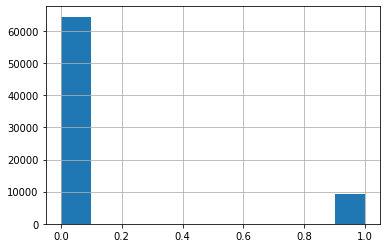

In [792]:
train.default.hist()

Целевые переменные имеют сильный дисбаланс

Смотрим что с education

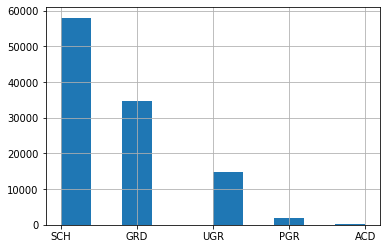

In [793]:
df.education.hist()

In [794]:
# Заполним education самым распространенным значением.
df.fillna(df.education.value_counts().index[0], inplace=True)

### Типизация

In [795]:
# Определим признаки, какие относятся к бинарным, какие к категориальным, числовым.
df.nunique()

client_id           110148
app_date               120
education                5
sex                      2
age                     52
car                      2
car_type                 2
decline_app_cnt         24
good_work                2
score_bki           102618
bki_request_cnt         40
region_rating            7
home_address             3
work_address             3
income                1207
sna                      4
first_time               4
foreign_passport         2
default                  2
Train                    2
mortality               52
crime                   11
dtype: int64

### бинарные признаки 

In [796]:
# бинарные признаки 
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

In [797]:
# Для бинарных признаков мы будем использовать LabelEncoder
label_encoder = LabelEncoder()
for column in bin_cols:
    df[column] = label_encoder.fit_transform(df[column])
    
# убедимся в преобразовании    
df[bin_cols].head()

,sex,car,car_type,good_work,foreign_passport
0,1,1,1,0,0
1,0,0,0,0,0
2,1,1,0,0,1
3,0,0,0,0,0
4,1,0,0,1,1


### категориальные переменные
---
education он единственный не числовой, также он содержит 5 уровней образования. Также region_rating - имеет 7 уровней ранжирование. Для них выполним ранжирование. 

*"SCH" - школьное "UGR" - бакалавр, "GRD - профессиональное", "PGR" - аспирантура, "ACD" - академическое*

In [798]:
# список уникальных значений по возростанию
grade = ['SCH', 'UGR', 'GRD', 'PGR', 'ACD'] 
# трансформация
df['education'] = OrdinalEncoder(categories=[grade]).fit_transform(
    df[['education']]).astype(int)

# отсортированный список уникальных значений по возростанию   
rating = sorted(df.region_rating.unique().tolist()) 
# трансформируем
df["region_rating"] = OrdinalEncoder(categories=[rating]).fit_transform(
    df[["region_rating"]]).astype(int)

In [799]:
# убедимся в преобразовании    
display(df['education'].value_counts())
df["region_rating"].value_counts()

0    58476
2    34768
1    14748
3     1865
4      291
Name: education, dtype: int64

3    40981
4    23999
2    17947
6    17170
5     9304
1      434
0      313
Name: region_rating, dtype: int64

Посмотрим на decline_app_cnt - и попробуем понять можно ли отнести к категориальным признакам.

In [800]:
df.decline_app_cnt.value_counts()

0     91471
1     12500
2      3622
3      1365
4       606
5       255
6       156
7        58
8        37
9        29
10       16
11       10
12        5
13        4
14        3
16        3
30        1
15        1
19        1
20        1
21        1
22        1
24        1
33        1
Name: decline_app_cnt, dtype: int64

Сделаем тоже самое с bki_request_cnt

In [801]:
# соберем единичные случаи в список
list_out = list(df.decline_app_cnt.value_counts()[16:].index)
# Заменим все значиния из списка на 17
df.decline_app_cnt = df.decline_app_cnt.apply(lambda x: 17 if x in list_out else x)

In [802]:
df.bki_request_cnt.value_counts()

0     28908
1     27295
2     20481
3     13670
4      8406
5      4960
6      2500
7      1292
8       735
9       459
10      350
11      278
12      217
13      151
14      110
15       81
16       58
17       33
18       32
19       30
21       19
20       14
23       12
24       12
22        8
25        5
27        5
28        5
26        4
32        4
29        3
33        2
40        2
41        1
46        1
45        1
47        1
36        1
34        1
53        1
Name: bki_request_cnt, dtype: int64

In [803]:
# соберем единичные случаи в список
list_out = list(df.bki_request_cnt.value_counts()[20:].index)
# Заменим все значиния из списка на 21
df.bki_request_cnt = df.bki_request_cnt.apply(lambda x: 21 if x in list_out else x)

In [804]:
# номинальные признаки OneHotEncoder
cat_cols = ['education', 'decline_app_cnt', 'bki_request_cnt', 'region_rating', 'home_address', 'work_address', \
            'sna', 'first_time', 'mortality', 'crime']

# Порядковые признаки OrdinalEncoder
# ordinal_cols

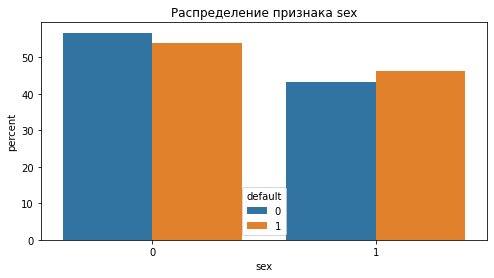

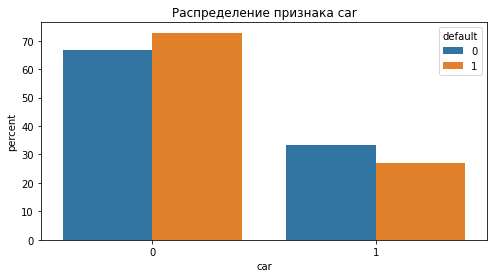

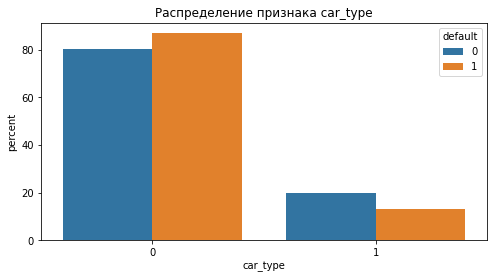

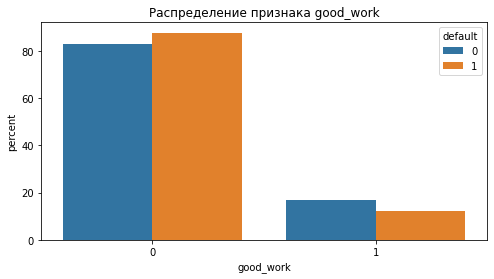

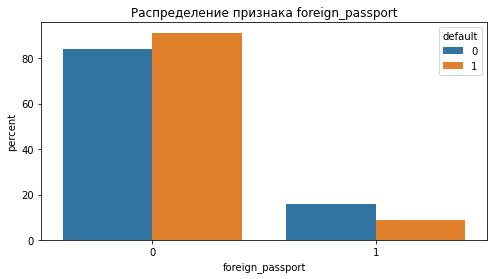

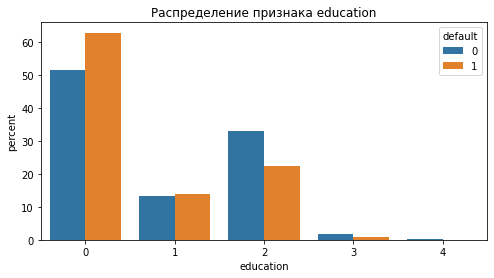

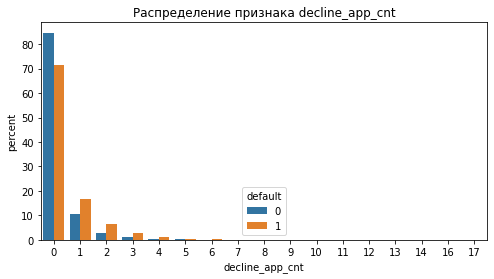

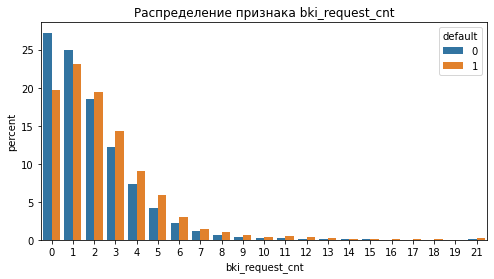

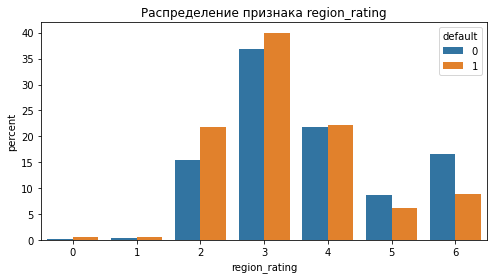

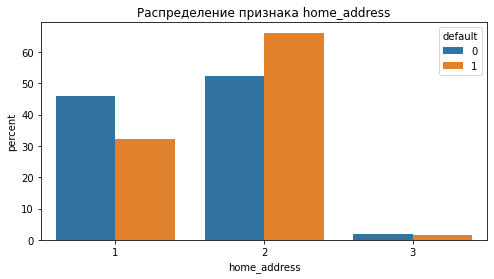

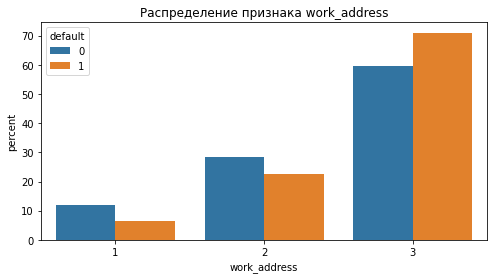

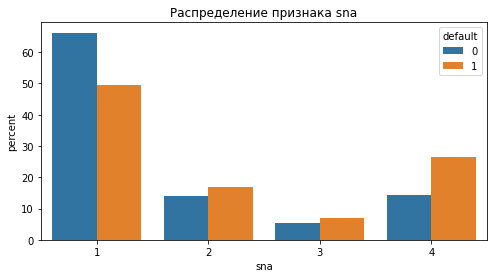

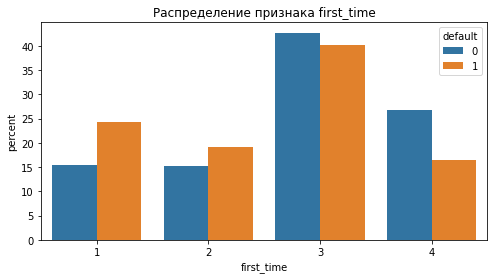

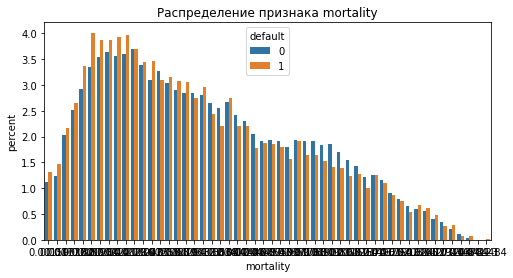

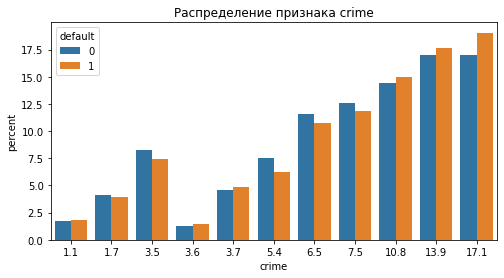

In [805]:
# теперь посмотрим распределение категориальных и бинарных признаков в зависимости от целевого признака
# графики показывают относительное распределение признаков по каждой группе клиентов: "хороших" и "плохих"
data = df[df['Train']]
for col in bin_cols + cat_cols:
    plt.figure(figsize=(8, 4))
    prop_df = data[col].groupby(data["default"]).value_counts(
        normalize=True).rename("percent").reset_index()
    prop_df["percent"] *= 100
    sns.barplot(x=col, y="percent", hue="default", data=prop_df)
    plt.title(f"Распределение признака {col}")

Выводы по категориальным признакам:

* sex: женщин в выборке немного больше, чем мужчин; женщины более часто отдают кредит, чем мужчины, но разница незначительна
* car: клиентов с машиной примерно в 2 раза меньше, чем без машины. Те, у кого есть машина, более кредитоспособны
* car_type: клиентов, у которой машина иномарка, еще меньше, и они также более кредитоспособны. 
* good_work: клиентов с хорошей работой значительно меньше, чем остальных и они более кредитоспособны
* foreign_passport: клиентов с загранпаспортом также значительно меньше остальных и они тоже более кредитоспособны
education: чем выше уровень образования у клиента, тем выше вероятность вернуть кредит
* region_rating: ординальный признак, принимающий значение от 0 до 4
* home_address: домашние адреса распределены по 3 категориям. Клиенты, проживающие в 1 категории адреса более кредитоспособны, чем во второй и в третьей
* work_address: рабочие адреса также распределены по 3 категориям. Клиенты, работающие в 1 и 2 категориях адреса более кредитоспособны, чем работающие в 3 категории
* sna (связь заемщика с клиентами банка): чем выше показатель, тем выше риск невозврата кредита

* first_time (давность наличия информациии о заемщике): чем выше показатель, тем более благонадежен клиент

### числовые признаки
----

Посмотрим на выбросы



In [806]:
# числовые признаки, client_id исключаем из списка. default - целевая переменная.
num_cols = ['age','score_bki','bki_request_cnt','income']


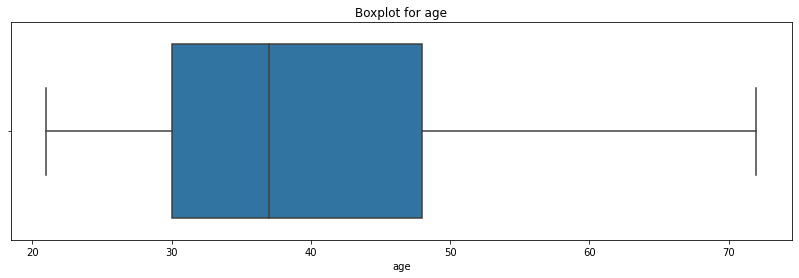

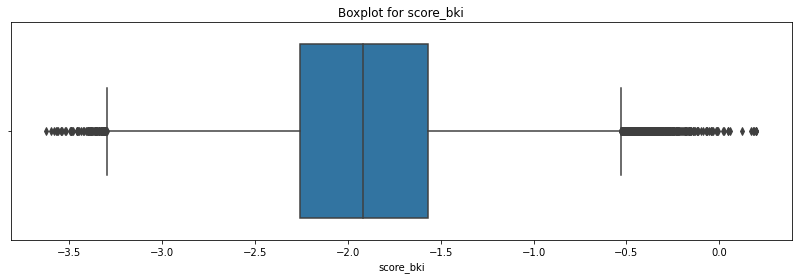

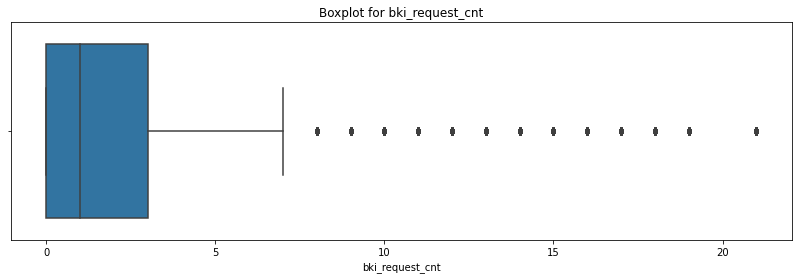

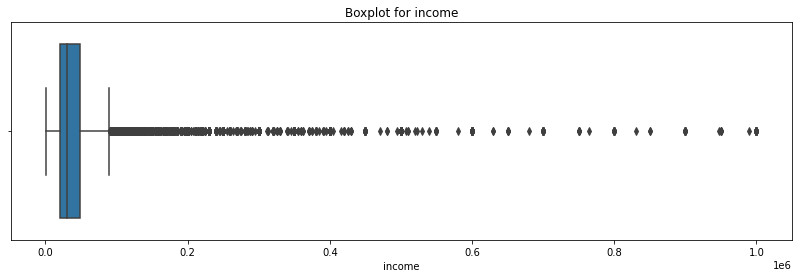

In [807]:
for col in num_cols:
    get_boxplot(col)

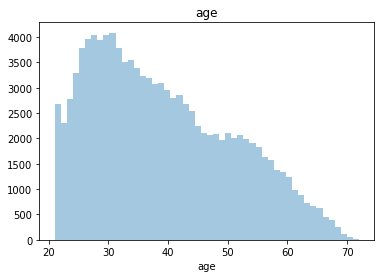

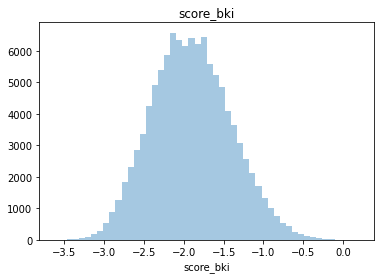

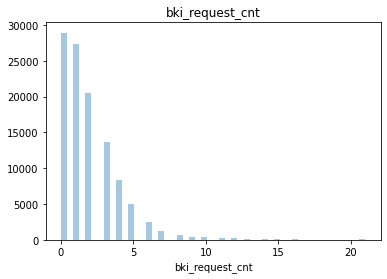

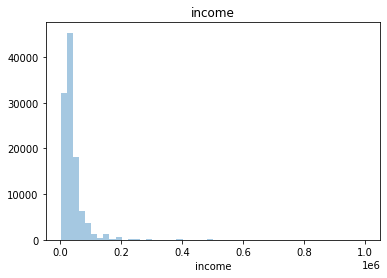

In [808]:
for i in num_cols:
    plt.figure()
    sns.distplot(df[i], kde = False, rug=False)
    plt.title(i)
    plt.show()

Числовые переменные (кроме score_bki, crime) имеют выбросы и/либо длинный правый хвост. Выполним логарифмирование для того чтобы распеределение стало более нормальным

In [809]:
log_list = ['age', 'decline_app_cnt', 'bki_request_cnt',\
            # 'income', 'mortality'
            ]
for col in log_list:
  df[col] = np.log(df[col] + 1)

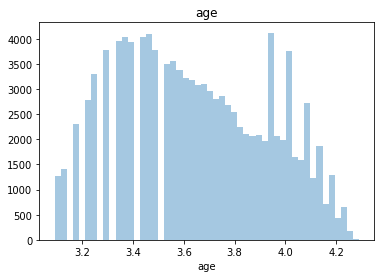

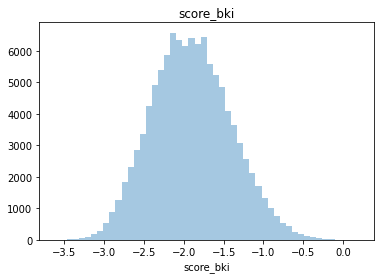

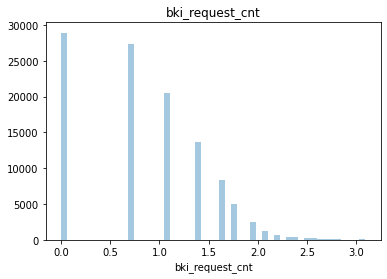

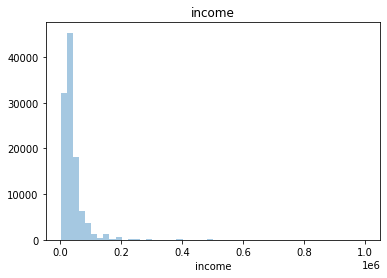

In [810]:
for i in num_cols:
    plt.figure()
    sns.distplot(df[i], kde = False, rug=False)
    plt.title(i)
    plt.show()

### Работа с датой

In [811]:
# дата - сразу сконветируем формат даты к удобному для работы
df.app_date = pd.to_datetime(df.app_date)
# Выведем количество дней и приведем к числовому призанку
df['app_date'] = (df.app_date - df.app_date.min()).dt.days.astype(int)
num_cols.append('app_date')

# Оценка корерляции и значимости признаков. 

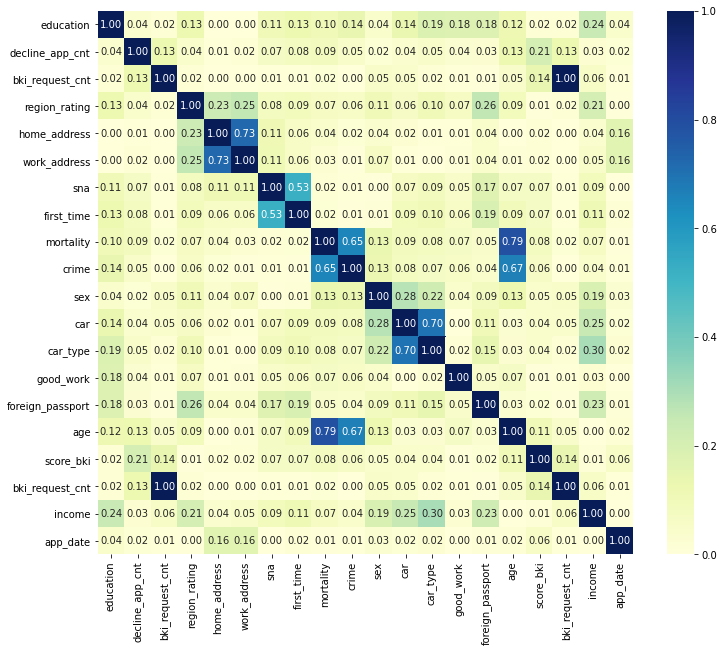

In [812]:
# посмотрим на корреляцию признаков между собой
plt.figure(figsize=(12, 10))
sns.heatmap(df[cat_cols+bin_cols+num_cols].corr().abs(), vmin=0,
            vmax=1, annot=True, fmt=".2f", cmap="YlGnBu")

# 6. Feature Engineering

Преобразуем в get_dummies категориальные признаки

## Создание полиномиальных признаков

In [813]:
# логарифмы численных фич(годовой заработок, сумма кр)
# объеденим адреса, т.к. они сильно коррелируют
df['adress'] = (df.work_address*df.home_address)**2
# df['adress_2'] = (df.work_address)**2
cat_cols.append('adress')
# cat_cols.append('adress_2')
cat_cols.remove('home_address')
cat_cols.remove('work_address')
df.drop(['home_address', 'work_address'], axis=1, inplace=True)

# объеденим car и car_type и переведем в категориальный признак
df['car_all'] = df['car'] + df['car_type']
df.drop(['car', 'car_type'], axis=1, inplace=True)
cat_cols.append('car_all')
bin_cols.remove('car')
bin_cols.remove('car_type')

In [814]:
df.sample(1)

,client_id,app_date,education,sex,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,income,sna,first_time,foreign_passport,default,Train,mortality,crime,adress,car_all
85301,100843,107,2,0,3.258097,0.0,0,-2.226239,0.0,3,10000,4,1,0,0,False,0.00187,17.1,4,0


In [815]:
df.shape

(110148, 20)

In [816]:
df['new1'] = np.sqrt(df.mortality*10000) * df.score_bki
df['new2'] = (df.score_bki * df.region_rating) / df.age
df['new4'] = (df.age / df.first_time) * df.score_bki
# num_cols_2 = ['age', 'crime', 'mortality']
df['new5'] = (df.score_bki * df.sna)
df['new6'] = df.crime * df.score_bki
df['new7'] = ((df.income**2) * df.first_time) / df.age
df['incomeˆ2'] = df['income']**2
df['incomeˆlog'] = np.log(df['income'] + 1)
df['incomeˆsqrt'] = np.sqrt(df['income'])
df['decline_app_cntˆ2'] = df['decline_app_cnt']**2
df['decline_app_cntˆ4'] = df['decline_app_cnt']**4
df['decline_app_cntˆlog'] = np.log(df['decline_app_cnt'] + 1)
df['decline_app_cntˆlog'] = np.sqrt(df['decline_app_cnt'])
df['bki_request_cntˆ2'] = df['bki_request_cnt']**2
df['bki_request_cntˆlog'] = np.log(df['bki_request_cnt'] + 1)

df['region_ratingˆ2'] = df['region_rating']**2
df['region_ratingˆlog'] = np.log(df['region_rating'] + 1)
df['region_ratingˆlog'] = np.sqrt(df['region_rating'])

df['score_bkiˆ2'] = df['score_bki']**2
df['score_bkiˆ4'] = df['score_bki']**4
df['score_bkiˆsqrt'] = np.sqrt(abs(df['score_bki']))
df['score_bkiˆlog'] = np.log(abs(df['score_bki']))
df['score_bkiˆexp'] = np.exp(abs(df['score_bki']))
df['daysˆ2'] = df['app_date']**2

In [817]:
# смотрим сколько стало столбцов
df.shape

(110148, 42)

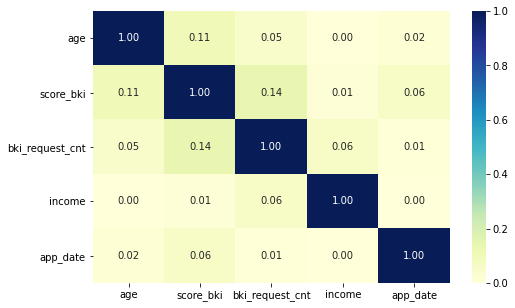

In [818]:
# посмотрим на корреляцию числовых признаков между собой
plt.figure(figsize=(8, 5))
sns.heatmap(df[num_cols].corr().abs(), vmin=0,
            vmax=1, annot=True, fmt=".2f", cmap="YlGnBu")

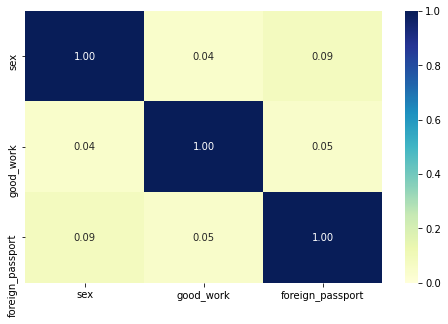

In [819]:
# посмотрим на корреляцию бинарных признаков между собой
plt.figure(figsize=(8, 5))
sns.heatmap(df[bin_cols].corr().abs(), vmin=0,
            vmax=1, annot=True, fmt=".2f", cmap="YlGnBu")

In [820]:
# df[rest_cols].max().sort_values()

## Удалим признаки с низким показателем значимости

Для оценки значимости числовых переменных будем использовать функцию f_classif из библиотеки sklearn. 

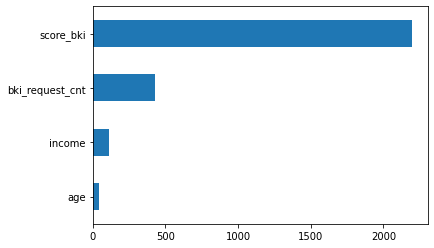

In [821]:
num_cols.remove('app_date')
imp_num = pd.Series(f_classif(df[num_cols], df['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [822]:
any_cols = ['client_id', 'Train', 'default']
rest_cols = list(set(df.columns) - set(cat_cols) - set(num_cols) - \
                  set(bin_cols) - set(any_cols))
len(rest_cols)

23

In [823]:
imp_rest = pd.Series(f_classif(df[rest_cols], df['default'])[0], index = rest_cols)
imp_rest.sort_values(inplace = True)
# imp_rest

In [824]:
# удалим первые незначительные элементы и обновим список rest_cols
rest_cols = imp_rest[imp_rest.values > 100].index

In [825]:
# 18 признаков из списка rest_cols удалилось
len(rest_cols)

20

In [826]:
any_cols = ['client_id', 'Train', 'default']
rest_cols = list(set(df.columns) - set(cat_cols) - set(num_cols) - \
                  set(bin_cols) - set(any_cols))
len(rest_cols)

23

При необходимости можно удалить сильно коррелирующие значения.

In [827]:
# посмотрим на корреляцию признаков rest_cols между собой
# plt.figure(figsize=(15, 15))
# sns.heatmap(df[rest_cols].corr().abs(), vmin=0,
#             vmax=1, annot=True, fmt=".2f", cmap="YlGnBu")

In [828]:
# # Создадим матрицу корреляции 
# corr_matrix = df.corr().abs()

# # Выделим сильно коррелирующие значения
# # Выберем верхний треугольник матрицы
# upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# # Найдем индексы столбцов с корреляцией более 0,95
# to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

In [829]:
# Drop features 
# df.drop(df[to_drop], axis=1, inplace=True)

In [830]:
# # обновим список rest_cols
# any_cols = ['client_id', 'Train', 'default']
# rest_cols = list(set(df.columns) - set(cat_cols) - set(num_cols) - \
#                   set(bin_cols) - set(any_cols))
# len(rest_cols)

In [831]:
# len(rest_cols+num_cols+bin_cols) # смотрим сколько нужных признаков

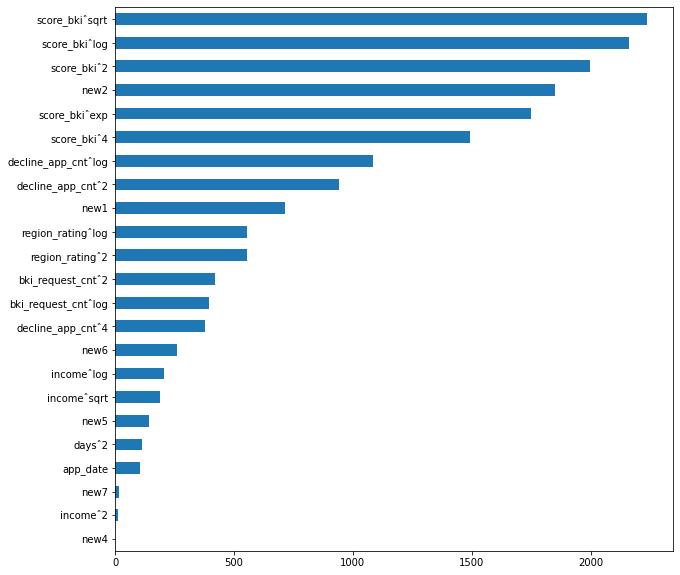

In [832]:
# Посмотрим на значимость новых признаков rest_cols

imp_rest = pd.Series(f_classif(df[rest_cols], df['default'])[0], index = rest_cols)
imp_rest.sort_values(inplace = True)
imp_rest.plot(kind = 'barh', figsize=(10, 10))

Для оценки значимости категориальных признаков будем использовать функцию mutual_info_classif из библиотеки sklearn.

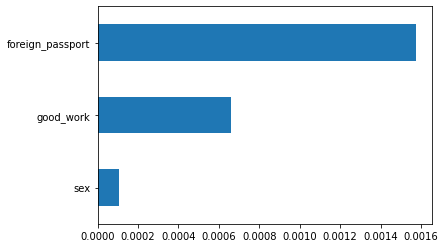

In [833]:
imp_cat = Series(mutual_info_classif(df[bin_cols], df['default'],
                                     discrete_features =True), index = bin_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

# 9. Подготовка данных к машинному обучению

Перед тем как мы будем выполнять масштабирование признаков, разделим на обратно на train и test.

In [834]:
train = df[df['Train']].drop('Train', axis=1) # сразу удаляем столбец Train
test = df[~df['Train']].drop('Train', axis=1)

Выполним сбалансированность данных, путем среза большинства/добавления меньшинства/сделаем усреднение.

In [835]:
# сбаланисруем модель в train удалив большинство
# shape = train.default.value_counts().values[1] # 9372 количество меньшего 
# df_big = train[train.default == 0].iloc[: shape] 
# df_min = train[train.default ==1] # меньшинство
# # объеденим 
# train = pd.concat([df_big, df_min])

In [836]:
# сбаланисруем модель в train увеличив меньшинство -- не влияет на модель.
# shape_min = train.default.value_counts().values[1]
# shape_max = train.default.value_counts().values[0]
# count = shape_max // shape_min
# res = pd.DataFrame(np.repeat(train[train.default ==1].values, count, axis=0),
#  columns=train.columns).astype(train.dtypes)
# # объеденим
# train = pd.concat([train, res])

In [837]:
# сбаланисруем модель в train сделав средний размер из большинства и меньшинства
df_big = train[train.default == 0] 
big = df_big.shape[0] # берем размер большинства
f_min = train[train.default ==1]
min = f_min.shape[0] # берем размер меньшинства
shape = round((big+min)/2) # берем средннее 
f'среднее количесвто строк {shape}'

'среднее количесвто строк 36900'

In [838]:
# возьмем чуть больше среднего 
df_big = train[train.default == 0].iloc[: int(shape*1.2)] 
df_big.shape

(44280, 41)

In [839]:
# смотрим во сколько раз среднее значение больше меньшинства
shape_min = train.default.value_counts().values[1]
round(shape/shape_min)

4

In [840]:
# Продублируем меньшинство в 4 раза и объеденим
count = round(shape/shape_min)
df_min = pd.DataFrame(np.repeat(train[train.default ==1].values, count, axis=0),
  columns=train.columns).astype(train.dtypes)
train = pd.concat([df_big, df_min])

In [841]:
train.shape

(81768, 41)

Стандартизируем числовые признаки и объединим бинарные категориальные переменные в одно признаковое пространство, отделив при этом признаки и целевую переменную.

In [842]:
def split_transform(df):  
  # Преобразуем катергориальные переменные в разряженную матрицу по методу getdummies
  enc_cols = OneHotEncoder(sparse = False).fit_transform(df[cat_cols].values)
  # encoder = OrdinalEncoder()
  # enc_cols = encoder.fit_transform(df[cat_cols].values)
  # Стандартизируем числовые переменые
  X_num = StandardScaler().fit_transform(df[num_cols].values)

  # Стандартизируем rest_cols - новые переменные
  X_rest_cols = StandardScaler().fit_transform(df[rest_cols].values)

  # Объединяем все признаки: cat_cols, num_cols, bin_cols
  X = np.hstack([X_num, X_rest_cols, df[bin_cols].values, enc_cols]) # X_cat,
  
  Y = df['default'].values
  poly = PolynomialFeatures(2)
  X_new = poly.fit_transform(df[['score_bki']])
  X = np.hstack([X, X_new])
  return X, Y

In [843]:
X, Y = split_transform(train)

Обучим модель на стандартных настройках логистической регрессии.

In [844]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=RANDOM_SEED)
model_sample = LogisticRegression(random_state=RANDOM_SEED)
model_sample.fit(X_train, y_train)
y_pred_pr = model_sample.predict_proba(X_test)
probs = y_pred_pr[:,1]
y_pred = model_sample.predict(X_test)


In [845]:
# Смотрим на метрики качества модели 0.743676		0.743635		
metric(X_test, y_test, y_pred, probs)

,Metrics,Result,Description
P,Positive,7497.000000,Дефолт
N,Negative,8857.000000,Без дефолта
TP,True positive,6484.000000,Истинно дефолтные
TN,True Negative,4657.000000,Истинно НЕ дефолтные
FP,False Positive,2373.000000,Ложно дефолтные
FN,False Negative,2840.000000,Ложно НЕ дефолтные
Accuracy,Accuracy,0.681240,Accuracy=(TP+TN)/(TP+TN+FP+FN)
Precision,Precision,0.662447,Точность = TP/(TP+FP)
Recall,Recall,0.621182,Полнота = TP/(TP+FN)
F1-score,F-мера,0.641151,Среднее гармоническое Precision и Recall


# Регуляризация

In [846]:
# grd_search(X_train, y_train) 
"""best_penalty=l2
best_c=2.7825594022071245
solver= liblinear
best_penalty=l2\nbest_c=7\nsolver= liblinear"""

'best_penalty=l2\nbest_c=2.7825594022071245\nsolver= liblinear\nbest_penalty=l2\nbest_c=7\nsolver= liblinear'

# Метрика + оценка качества предсказательной модели
----
Немного разберемся по мтерикам качества модели:
* **TP** - истинно положительные решения
* **TN** - истинно негативные решения
* **FP** - ложно положительные решения
* **FN** - ложно негативные решения
* **Accuracy**( - доля объектов к которым алгоритм отнес в верному классу, среди всех объектов. Не подходит для не сбалансированных классов.
* **Precision**(точность) - доля объектов действительно принадлежащих данному классу относительно всех объектов, которые алгоритм отнес к этому классу.
* **Recall** - доля найденных классификатором объектов, принадлежащих классу относительно всех объектов, которые принадлежат этому классу(доля положительных среди всех положительных).
* **confusion_matrix** - 

In [847]:
# Применим рекомендованные параметры C=7 0.743841	
# model_rec = LogisticRegression(C=7, class_weight='balanced'\
#                                   , random_state=RANDOM_SEED, solver='liblinear' )
# model_rec.fit(X_train, y_train)
# y_pred_pr = model_rec.predict_proba(X_test)
# probs = y_pred_pr[:,1]
# y_pred = model_rec.predict(X_test)
# metric(X_test, y_test, y_pred, probs)

In [848]:
# model_rec = LogisticRegressionCV(random_state=RANDOM_SEED)
# model_rec.fit(X_train, y_train)
# y_pred_pr = model_rec.predict_proba(X_test)
# probs = y_pred_pr[:,1]
# y_pred = model_rec.predict(X_test)
# metric(X_test, y_test, y_pred, probs)

In [857]:
def Log_Reg(X, Y):  
  model = LogisticRegression(C=7
                                  , random_state=RANDOM_SEED, solver='liblinear')
  skf = StratifiedKFold(n_splits=5, random_state=RANDOM_SEED, shuffle=False )
  kf = KFold(n_splits=5, random_state=RANDOM_SEED, shuffle=False)
  # sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
  for train_index, test_index in skf.split(X, Y):
    # print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    model.fit(X_train, y_train)
    return model


In [858]:
# # Применим метод с KFold разбиением
model = Log_Reg(X_train, y_train)
y_pred_pr = model_rec.predict_proba(X_test)
probs = y_pred_pr[:,1]
y_pred = model_rec.predict(X_test)
metric(X_test, y_test, y_pred, probs) #	0.743800		

,Metrics,Result,Description
P,Positive,7497.000000,Дефолт
N,Negative,8857.000000,Без дефолта
TP,True positive,6482.000000,Истинно дефолтные
TN,True Negative,4667.000000,Истинно НЕ дефолтные
FP,False Positive,2375.000000,Ложно дефолтные
FN,False Negative,2830.000000,Ложно НЕ дефолтные
Accuracy,Accuracy,0.681729,Accuracy=(TP+TN)/(TP+TN+FP+FN)
Precision,Precision,0.662738,Точность = TP/(TP+FP)
Recall,Recall,0.622516,Полнота = TP/(TP+FN)
F1-score,F-мера,0.641997,Среднее гармоническое Precision и Recall


In [851]:
"""Очень долго вычисляет"""
# parameters = {'C': list(np.linspace(0, 1, num=10))}
# model = LogisticRegression(class_weight="balanced",
#                            max_iter=800,
#                            solver='sag',
#                            random_state=RANDOM_SEED)
# grid_search_cv_fr = GridSearchCV(model, parameters, n_jobs=-1)
# grid_search_cv_fr.fit(X_train, y_train)

# bestgrid_search_cv_fr = grid_search_cv_fr.best_params_
# model_rec = grid_search_cv_fr.best_estimator_
# model_rec.fit(X_train, y_train)

# y_pred_pr = model_rec.predict_proba(X_test)
# probs = y_pred_pr[:,1]
# y_pred = model_rec.predict(X_test)
# metric(X_test, y_test, y_pred, probs)

'Очень долго вычисляет'

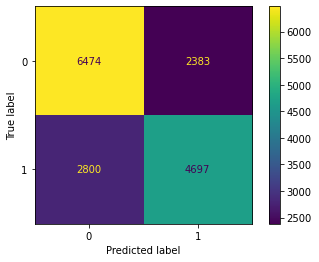

In [859]:
plot_confusion_matrix(model, X_test, y_test, values_format='3g')  # 	TP: 5923	FP: 2934
                                                                  # 	FN: 2344	TN: 5153  

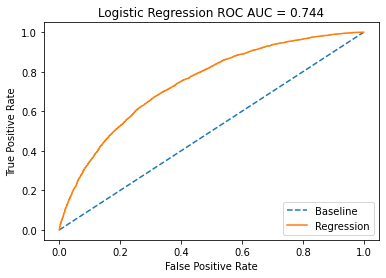

In [860]:
# строим ROC кривую 0.743
fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [854]:
# Обучим модель на всем Train
model = Log_Reg(X, Y)

Преобразуем катергориальные переменные в разряженную матрицу и вернем X_Test
X_Test, Y_Test = split_transform(test)

y_pred = model.predict(X_Test)
y_pred_prob = model.predict_proba(X_Test)[:,1]
submit = pd.DataFrame(test.client_id)
submit['default']=y_pred_prob
submit.to_csv('/content/drive/MyDrive/Colab Notebooks/modul/skillfactory_rds/submission.csv', index=False)